# **1.Time Benchmark**

In [2]:
import pandas as pd
df = pd.read_csv('../../Data/AAM/unbalance/mapping_times.csv', index_col=0)
#df.rename(columns={'Unnamed: 0': 'dataset'}, inplace=True)
#df['Number of Reactions'] = [273, 382, 3000, 1758, 491]
df

,rxn_mapper,graphormer,local_mapper,rdt
ecoli,5.130781,24.713289,40.292902,1189.930139
recon3d,9.875396,45.715260,83.690366,3156.964881
uspto_3k,40.375809,245.452059,311.176631,12281.490290
golden,20.297005,120.641184,154.832556,5028.393047
natcomm,5.339799,30.891627,38.848256,1053.318801


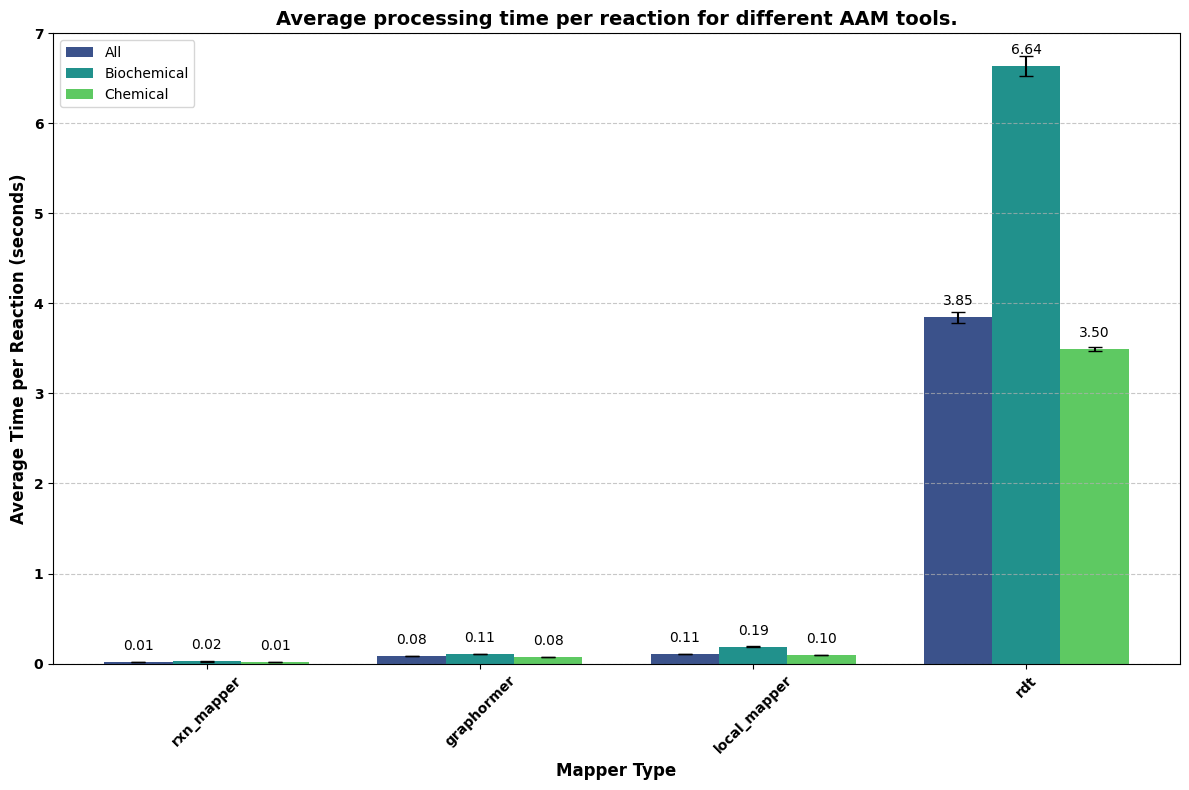

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Set color palette
colors = sns.color_palette("viridis", n_colors=3)  # 3 shades for all, biochemical, and chemical

# Plotting
plt.figure(figsize=(12, 8))

# Define bar width and positions
bar_width = 0.25
x = np.arange(len(df.columns[:-1]))  # Position indexes for mappers

# Plot each category for mappers with error bars
for i, mapper in enumerate(df.columns[:-1]):
    # 'All' category
    all_avg = df[mapper].sum() / df['Number of Reactions'].sum()
    all_std = np.sqrt(np.sum((df[mapper]/df['Number of Reactions']- all_avg) ** 2) / df['Number of Reactions'].sum())

    plt.bar(x[i] - bar_width, all_avg, width=bar_width, color=colors[0], label='All' if i == 0 else "", yerr=all_std, capsize=5)

    # 'Biochemical' category
    bio_avg = df[mapper][:2].sum() / df['Number of Reactions'][:2].sum()
    bio_std = np.sqrt(np.sum((df[mapper][:2]/ df['Number of Reactions'][:2] - bio_avg) ** 2) / df['Number of Reactions'][:2].sum())

    plt.bar(x[i], bio_avg, width=bar_width, color=colors[1], label='Biochemical' if i == 0 else "", yerr=bio_std, capsize=5)

    # 'Chemical' category
    chem_avg = df[mapper][2:].sum() / df['Number of Reactions'][2:].sum()
    chem_std = np.sqrt(np.sum((df[mapper][2:]/ df['Number of Reactions'][2:] - chem_avg) ** 2) / df['Number of Reactions'][2:].sum())

    plt.bar(x[i] + bar_width, chem_avg, width=bar_width, color=colors[2], label='Chemical' if i == 0 else "", yerr=chem_std, capsize=5)

    # Adding text labels for average times
    label_offset = 0.1  # Constant offset for label placement
    plt.text(x[i] - bar_width, all_avg + label_offset, f'{all_avg:.2f}', ha='center', va='bottom')
    plt.text(x[i], bio_avg + label_offset, f'{bio_avg:.2f}', ha='center', va='bottom')
    plt.text(x[i] + bar_width, chem_avg + label_offset, f'{chem_avg:.2f}', ha='center', va='bottom')

plt.xlabel('Mapper Type', fontsize=12, weight='bold')
plt.ylabel('Average Time per Reaction (seconds)', fontsize=12, weight='bold')
plt.title('Average processing time per reaction for different AAM tools.', fontsize=14, weight='bold')
plt.xticks(x, df.columns[:-1], rotation=45, fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper left')
plt.ylim(0, 7)  # Set y-axis limits to start from 0 to 20 seconds

plt.tight_layout()
plt.show()


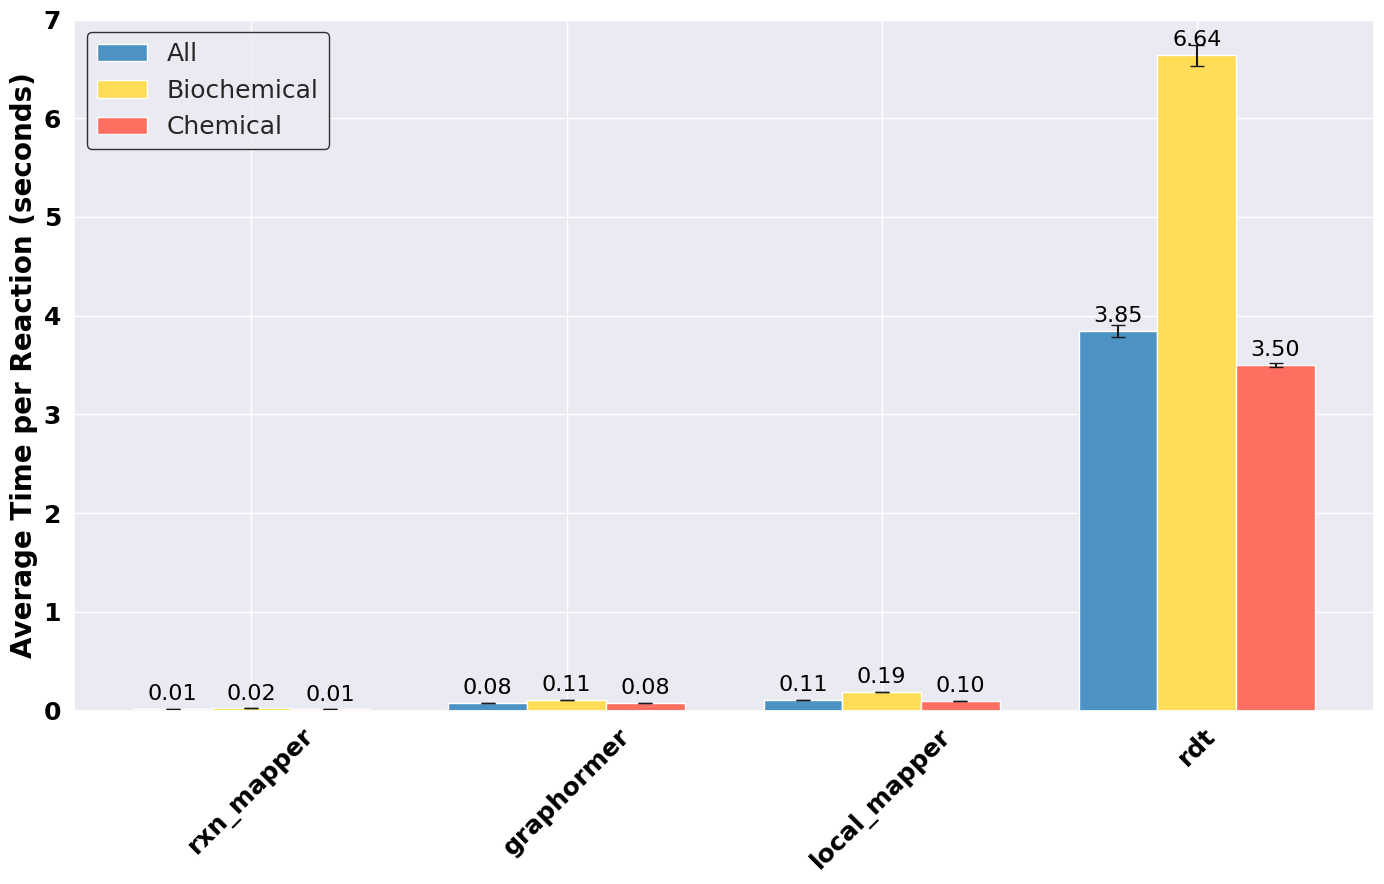

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

colors = ["#4c92c3", "#ffdd57", "#ff6f61"]  # More vibrant colors for differentiation

# Plotting
plt.figure(figsize=(14, 9))
sns.set(style="darkgrid")  # Correct style for background grid

# Define bar width and positions
bar_width = 0.25
x = np.arange(len(df.columns[:-1]))  # Position indexes for mappers

# Plot each category for mappers with error bars
for i, mapper in enumerate(df.columns[:-1]):
    # 'All' category
    all_avg = df[mapper].sum() / df['Number of Reactions'].sum()
    all_std = np.sqrt(np.sum((df[mapper]/df['Number of Reactions']- all_avg) ** 2) / df['Number of Reactions'].sum())

    # 'Biochemical' category
    bio_avg = df[mapper][:2].sum() / df['Number of Reactions'][:2].sum()
    bio_std = np.sqrt(np.sum((df[mapper][:2]/ df['Number of Reactions'][:2] - bio_avg) ** 2) / df['Number of Reactions'][:2].sum())
 
    # 'Chemical' category
    chem_avg = df[mapper][2:].sum() / df['Number of Reactions'][2:].sum()
    chem_std = np.sqrt(np.sum((df[mapper][2:]/ df['Number of Reactions'][2:] - chem_avg) ** 2) / df['Number of Reactions'][2:].sum())

    plt.bar(x[i] - bar_width, all_avg, width=bar_width, color=colors[0], label='All' if i == 0 else "", yerr=all_std, capsize=5)
    plt.bar(x[i], bio_avg, width=bar_width, color=colors[1], label='Biochemical' if i == 0 else "", yerr=bio_std, capsize=5)
    plt.bar(x[i] + bar_width, chem_avg, width=bar_width, color=colors[2], label='Chemical' if i == 0 else "", yerr=chem_std, capsize=5)

    # Text labels for average times
    label_offset = 0.05  # Constant offset for label placement
    plt.text(x[i] - bar_width, all_avg + label_offset, f'{all_avg:.2f}', ha='center', va='bottom', color='black', fontsize=16)
    plt.text(x[i], bio_avg + label_offset, f'{bio_avg:.2f}', ha='center', va='bottom', color='black', fontsize=16)
    plt.text(x[i] + bar_width, chem_avg + label_offset, f'{chem_avg:.2f}', ha='center', va='bottom', color='black', fontsize=16)

#plt.xlabel('Mapper Type', fontsize=14, weight='bold', color='black')
plt.ylabel('Average Time per Reaction (seconds)', fontsize=20, weight='bold', color='black')
#plt.title('Average processing time per reaction for different AAM tools', fontsize=16, weight='bold', color='black')

plt.xticks(x, df.columns[:-1], rotation=45, fontsize=18, weight='bold', color='black')
plt.yticks(fontsize=18, weight='bold', color='black')
plt.legend(fontsize=18, loc='upper left', frameon=True, edgecolor='black')
plt.ylim(0, 7)  # Set y-axis limits to start from 0 to 20 seconds

plt.tight_layout()
plt.savefig('./fig/aam_time_benchmark.pdf', dpi = 600)
plt.show()


# **2. Success rate Benchmark**

In [1]:
import re

def calculate_mapping_failures(data):
    """
    Calculates the number of failed mappings based on the absence of atom maps in the reaction data.
    Args:
    data (list of dicts): A list of dictionaries where each dictionary represents reaction data.

    Returns:
    dict: A dictionary containing the number of fails and success rates for each mapper type.
    """
    
    # Keys to evaluate
    keys_to_check = ['rxn_mapper', 'graphormer', 'local_mapper', 'rdt']
    
    # Initialize results dictionary to store fails and successes
    results = {key: {'fails': 0, 'successes': 0} for key in keys_to_check}
    
    # Regex pattern to find atom maps
    atom_map_pattern = re.compile(r':\d+')
    
    # Process each dictionary in the list
    for entry in data:
        for key in keys_to_check:
            # Get the reaction data
            reaction_data = entry.get(key, "")
            
            # Check if the reaction contains any atom maps
            if re.search(atom_map_pattern, reaction_data):
                results[key]['successes'] += 1
            else:
                results[key]['fails'] += 1
    
    # Prepare aggregate results to provide total fails and success rates
    aggregate_results = {}
    for key in keys_to_check:
        total_fails = results[key]['fails']
        total_successes = results[key]['successes']
        total_attempts = total_fails + total_successes
        success_rate = (total_successes / total_attempts) if total_attempts > 0 else 0

        aggregate_results[f"{key}_number_fails"] = int(total_fails)
        aggregate_results[f"{key}_success_rate"] = round(success_rate * 100, 2)  # Express as percentage
    
    return aggregate_results


In [2]:
import sys
sys.path.append('../../')
from SynTemp.SynUtils.utils import load_database
data = load_database('../../Data/AAM/unbalance/golden/golden_aam_reactions.json.gz')

In [3]:
test  =[value['rdt'] for value in data]

In [4]:
import re
def mapping_success_rate(list_mapping_data):
    """
    Calculate the success rate of entries containing atom mappings in a list of data strings.
    
    Parameters:
        list_mapping_in_data (list of str): List containing strings to be searched for atom mappings.
    
    Returns:
        float: The success rate of finding atom mappings in the list as a percentage.
    
    Raises:
        ValueError: If the input list is empty.
    """
    atom_map_pattern = re.compile(r':\d+')
    if not list_mapping_data:
        raise ValueError("The input list is empty, cannot calculate success rate.")
    
    success = sum(1 for entry in list_mapping_data if re.search(atom_map_pattern, entry))
    rate = 100 * (success / len(list_mapping_data))
    
    return round(rate, 2)


In [24]:
import networkx as nx
import pandas as pd
from typing import Dict, List, Tuple, Union, Optional
from rdkit import Chem
from operator import eq
from joblib import Parallel, delayed
from networkx.algorithms.isomorphism import generic_node_match, generic_edge_match
from SynTemp.SynITS.its_construction import ITSConstruction
from SynTemp.SynITS.its_extraction import ITSExtraction
from SynTemp.SynChemistry.mol_to_graph import MolToGraph
from SynTemp.SynRule.rules_extraction import RuleExtraction
from SynTemp.SynUtils.chemutils import enumerate_tautomers, mapping_success_rate
from itertools import combinations


class AMMValidator:
    def __init__(self):
        """Initializes the AMMValidator class."""
        pass

    @staticmethod
    def graph_from_smiles(smiles: str) -> nx.Graph:
        """
        Constructs a graph representation from a SMILES string.

        Parameters:
            smiles (str): A SMILES string representing a molecule or a set of molecules.

        Returns:
            nx.Graph: A graph representation of the molecule(s).
        """
        mol = Chem.MolFromSmiles(smiles)
        graph = MolToGraph().mol_to_graph(mol, drop_non_aam=True)
        return graph

    @staticmethod
    def check_equivariant_graph(
        its_graphs: List[nx.Graph],
    ) -> Tuple[List[Tuple[int, int]], int]:
        """
        Checks for isomorphism among a list of ITS graphs and
        identifies all pairs of isomorphic graphs.

        Parameters:
        - its_graphs (List[nx.Graph]): A list of ITS graphs.

        Returns:
        - List[Tuple[int, int]]: A list of tuples representing
                pairs of indices of isomorphic graphs.
        - int: The count of unique isomorphic graph pairs found.
        """
        nodeLabelNames = ["typesGH"]
        nodeLabelDefault = ["*", False, 0, 0, ()]
        nodeLabelOperator = [eq, eq, eq, eq, eq]
        nodeMatch = generic_node_match(
            nodeLabelNames, nodeLabelDefault, nodeLabelOperator
        )
        edgeMatch = generic_edge_match("order", 1, eq)

        classified = []

        # Use combinations to check each unique pair of graphs without repetition
        for i, j in combinations(range(len(its_graphs)), 2):
            if nx.is_isomorphic(
                its_graphs[i], its_graphs[j], node_match=nodeMatch, edge_match=edgeMatch
            ):
                classified.append((i, j))

        return classified, len(classified)

    @staticmethod
    def smiles_check(
        mapped_smile: str,
        ground_truth: str,
        check_method: str = "RC",  # or 'ITS'
        ignore_aromaticity: bool = False,
    ) -> bool:
        """
        Checks the equivalence of mapped SMILES against ground truth
        using reaction center (RC) or ITS graph method.

        Parameters:
            mapped_smile (str): The mapped SMILES string.
            ground_truth (str): The ground truth SMILES string.
            check_method (str): The method used for validation
            ('RC' or 'ITS').
            ignore_aromaticity (bool): Flag to ignore aromaticity
                                        in ITS graph construction.

        Returns:
            bool: True if the mapped SMILES is equivalent to the ground truth,
                    False otherwise.
        """
        its_graphs = []
        rules_graphs = []
        try:
            for rsmi in [mapped_smile, ground_truth]:
                reactants_side, products_side = rsmi.split(">>")
                G = AMMValidator.graph_from_smiles(reactants_side)  # Reactants graph
                H = AMMValidator.graph_from_smiles(products_side)  # Products graph

                ITS = ITSConstruction.ITSGraph(G, H, ignore_aromaticity)
                its_graphs.append(ITS)

                rules = RuleExtraction.extract_reaction_rules(G, H, ITS, extend=False)
                rules_graphs.append(rules[2])

            _, equivariant = AMMValidator.check_equivariant_graph(
                rules_graphs if check_method == "RC" else its_graphs
            )

            return equivariant == 1

        except Exception as e:  # Catch more general exceptions
            print("An error occurred:", str(e))
            return False
        
    def smiles_check_tautomer(
        mapped_smile: str,
        ground_truth: str,
        check_method: str = "RC",  # or 'ITS'
        ignore_aromaticity: bool = False,
    ) -> Optional[bool]:
        """
        Determines if a given mapped SMILE string is equivalent to any tautomer of a ground truth SMILES string
        using a specified comparison method.

        The function first enumerates all possible tautomers of the ground truth SMILES and then checks
        if the mapped SMILE string matches any of these tautomers based on the specified method.

        Args:
            mapped_smile (str): The SMILES string to check against the tautomers of the ground truth.
            ground_truth (str): The reference SMILES string for generating possible tautomers.
            check_method (str): The method to use for checking equivalence. Possible values are "RC" for
                                relaxed chemical transformation or "ITS" for isomorphic tautomer search.
                                Default is "RC".
            ignore_aromaticity (bool): If True, the comparison ignores differences in aromaticity between
                                       the mapped SMILE and the tautomers. Default is False.

        Returns:
            Optional[bool]: True if the mapped SMILE matches any of the enumerated tautomers of the ground truth
                            according to the specified check method. Returns False if no match is found.
                            Returns None if an error occurs during processing.

        Raises:
            Exception: If an error occurs during the tautomer enumeration or during the comparison process.
        """
        try:
            ground_truth_tautomers = enumerate_tautomers(ground_truth)
            return any(AMMValidator.smiles_check(mapped_smile, t, check_method, ignore_aromaticity) for t in ground_truth_tautomers)
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    @staticmethod
    def check_pair(
        mapping: Dict[str, str],
        mapped_col: str,
        ground_truth_col: str,
        check_method: str = "RC",
        ignore_aromaticity: bool = False,
        ignore_tautomers: bool = True
    ) -> bool:
        """
        Checks the equivalence between the mapped and ground truth
        values within a given mapping dictionary, using a specified check method.
        The check can optionally ignore aromaticity.

        Parameters:
        - mapping (Dict[str, str]): A dictionary containing the data entries to check.
        - mapped_col (str): The key in the mapping dictionary corresponding
                                    to the mapped value.
        - ground_truth_col (str): The key in the mapping dictionary corresponding
                                    to the ground truth value.
        - check_method (str, optional): The method used for checking the equivalence.
                                    Defaults to 'RC'.
        - ignore_aromaticity (bool, optional): Flag to indicate whether aromaticity
                                    should be ignored during the check.
                                    Defaults to False.
        - ignore_tautomers (bool, optional): Flag to indicate whether tautomers
                                    should be ignored during the check.
                                    Defaults to False.

        Returns:
        - bool: The result of the check, indicating whether the mapped value is
                equivalent to the ground truth according to the specified method
                and considerations regarding aromaticity.
        """
        if ignore_tautomers:
            return AMMValidator.smiles_check(
                mapping[mapped_col],
                mapping[ground_truth_col],
                check_method,
                ignore_aromaticity,
            )
        else:
            return AMMValidator.smiles_check_tautomer(
                mapping[mapped_col],
                mapping[ground_truth_col],
                check_method,
                ignore_aromaticity,
            )

    @staticmethod
    def validate_smiles(
        data: Union[pd.DataFrame, List[Dict[str, str]]],
        id_col: str = "R-id",
        ground_truth_col: str = "ground_truth",
        mapped_cols: List[str] = ["rxn_mapper", "graphormer", "local_mapper"],
        check_method: str = "RC",
        ignore_aromaticity: bool = False,
        n_jobs: int = 1,
        verbose: int = 0,
        ensemble=False,
        strategies=[
            ["rxn_mapper", "graphormer", "local_mapper"],
            ["rxn_mapper", "graphormer", "local_mapper", "rdt"],
        ],
        ignore_tautomers=True
    ) -> List[Dict[str, Union[str, float, List[bool]]]]:
        """
        Validates collections of mapped SMILES against their ground truths
        for multiple mappers and calculates the accuracy.

        Parameters:
            data (Union[pd.DataFrame, List[Dict[str, str]]]): The input data
                                    containing mapped and ground truth SMILES.
            id_col (str): The name of the column or key containing
                                    the reaction ID.
            ground_truth_col (str): The name of the column or key containing
                                    the ground truth SMILES.
            mapped_cols (List[str]): The list of columns or keys containing
                                    the mapped SMILES for different mappers.
            check_method (str): The method used for validation ('RC' or 'ITS').
            ignore_aromaticity (bool): Whether to ignore aromaticity
                                    in ITS graph construction.
            n_jobs (int): The number of parallel jobs to run.
            verbose (int): The verbosity level for joblib's parallel execution.

        Returns:
            List[Dict[str, Union[str, float, List[bool]]]]: A list of dictionaries,
            each containing the mapper name,
            accuracy, and individual results for each SMILES pair.
        """
        validation_results = []

        for mapped_col in mapped_cols:

            if isinstance(data, pd.DataFrame):
                mappings = data.to_dict("records")
            elif isinstance(data, list):
                mappings = data
            else:
                raise ValueError(
                    "Data must be either a pandas DataFrame or a list of dictionaries."
                )

            # Use joblib to parallelize the validation checks
            results = Parallel(n_jobs=n_jobs, verbose=verbose)(
                delayed(AMMValidator.check_pair)(
                    mapping,
                    mapped_col,
                    ground_truth_col,
                    check_method,
                    ignore_aromaticity,
                    ignore_tautomers
                )
                for mapping in mappings
            )
            accuracy = sum(results) / len(mappings) if mappings else 0
            mapped_data = [value[mapped_col] for value in mappings]
            # Store the results for each mapper in the list
            validation_results.append(
                {
                    "mapper": mapped_col,
                    "accuracy": round(100*accuracy,2),
                    "results": results,
                    "success_rate": mapping_success_rate(mapped_data),
                }
            )
        if ensemble:
            for key, strategy in enumerate(strategies):
                mapped_cols = strategy
                threshold = len(mapped_cols) - 1

                its_graph, _ = ITSExtraction.parallel_process_smiles(
                    mappings,
                    mapped_cols,
                    threshold=threshold,
                    n_jobs=n_jobs,
                    verbose=verbose,
                    export_full=False,
                    check_method=check_method,
                )
                id = [value["R-id"] for value in its_graph]
                data_ensemble = [value for value in mappings if value["R-id"] in id]
                data_ensemble = [
                    {
                        id_col: value[id_col],
                        f"ensemble_{key+1}": value[mapped_cols[-1]],
                        ground_truth_col: value[ground_truth_col],
                    }
                    for value in data_ensemble
                ]
                results = Parallel(n_jobs=n_jobs, verbose=verbose)(
                    delayed(AMMValidator.check_pair)(
                        mapping,
                        f"ensemble_{key+1}",
                        ground_truth_col,
                        check_method,
                        ignore_aromaticity,
                        ignore_tautomers
                    )
                    for mapping in data_ensemble
                )
                accuracy = sum(results) / len(data_ensemble)
                validation_results.append(
                    {
                        "mapper": f"ensemble_{key+1}",
                        "accuracy": round(100*accuracy,2),
                        "results": results,
                        "success_rate": round(100 * len(data_ensemble) / len(mappings),2),
                    }
                )

        return validation_results, data_ensemble if ensemble else None


In [25]:
results, _ = AMMValidator.validate_smiles(
            data=data,
            ground_truth_col="ground_truth",
            mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
            check_method="RC",
            ignore_aromaticity=False,
            n_jobs=4,
            verbose=2,
            ensemble=True,
            strategies = [["rxn_mapper", "graphormer", "local_mapper"], ["rxn_mapper", "graphormer", "local_mapper", "rdt"]],
            ignore_tautomers=False
    )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    1.1s
[14:01:15] Can't kekulize mol.  Unkekulized atoms: 2 6
[14:01:15] Tautomer enumeration stopped at 288 tautomers: max transforms reached
[14:01:16] Tautomer enumeration stopped at 577 tautomers: max transforms reached
[14:01:17] Tautomer enumeration stopped at 414 tautomers: max transforms reached
[14:01:18] Tautomer enumeration stopped at 424 tautomers: max transforms reached
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 2 6
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 2 6
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 28 32
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 28 32
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 28 32
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 28 32
[14:01:18] Can't kekulize mol.  Unkekulized atoms: 28 32
[14:01:19] WARNING: not removing hydrogen atom without neighbors
[14:01:19] WARNING: not r

In [23]:
pd.DataFrame(results)

,mapper,accuracy,results,success_rate
0,rxn_mapper,0.874289,"[False, True, False, True, False, False, False...",100.00
1,graphormer,0.895904,"[False, True, True, True, True, False, False, ...",100.00
2,local_mapper,0.890785,"[False, True, True, True, True, False, False, ...",100.00
3,rdt,0.825370,"[False, False, False, True, False, False, True...",99.77
4,ensemble_1,0.986111,"[False, True, True, True, True, True, True, Tr...",73.72
5,ensemble_2,0.992373,"[False, True, True, True, True, True, True, Tr...",67.12


In [10]:
import sys
sys.path.append('../..')
from SynTemp.SynUtils.utils import load_database

data_paths = {
    'ecoli': '../../Data/AAM/unbalance/ecoli/ecoli_aam_reactions.json.gz',
    'recon3d': '../../Data/AAM/unbalance/recon3d/recon3d_aam_reactions.json.gz',
    'uspto_3k': '../../Data/AAM/unbalance/uspto_3k/uspto_3k_aam_reactions.json.gz',
    'golden': '../../Data/AAM/unbalance/golden/golden_aam_reactions.json.gz',
    'natcomm': '../../Data/AAM/unbalance/natcomm/natcomm_aam_reactions.json.gz'
}

# Dictionary to hold the results for each dataset
results_dict = {}

# Process each dataset
for dataset_name, filepath in data_paths.items():
    # Load the data
    data = load_database(filepath)
    
    # Calculate fails and success rates
    results = calculate_mapping_failures(data)
    
    # Store the results
    results_dict[dataset_name] = results

# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results_dict, orient='index')

# Display or save the DataFrame
df_results.T

,ecoli,recon3d,uspto_3k,golden,natcomm
rxn_mapper_number_fails,0.0,0.0,0.0,0.00,0.00
rxn_mapper_success_rate,100.0,100.0,100.0,100.00,100.00
graphormer_number_fails,0.0,0.0,0.0,0.00,0.00
graphormer_success_rate,100.0,100.0,100.0,100.00,100.00
local_mapper_number_fails,0.0,0.0,0.0,0.00,0.00
local_mapper_success_rate,100.0,100.0,100.0,100.00,100.00
rdt_number_fails,0.0,0.0,0.0,4.00,4.00
rdt_success_rate,100.0,100.0,100.0,99.77,99.19


# **3. Accuracy Benchmark**

In [2]:
import sys
import pandas as pd
sys.path.append('../..')
from SynTemp.SynAAM.aam_validator import AMMValidator

In [ ]:
data_paths = {
    'ecoli': '../../Data/AAM/unbalance/ecoli/ecoli_aam_reactions.json.gz',
    'recon3d': '../../Data/AAM/unbalance/recon3d/recon3d_aam_reactions.json.gz',
    'uspto_3k': '../../Data/AAM/unbalance/uspto_3k/uspto_3k_aam_reactions.json.gz',
    'golden': '../../Data/AAM/unbalance/golden/golden_aam_reactions.json.gz',
    'natcomm': '../../Data/AAM/unbalance/natcomm/natcomm_aam_reactions.json.gz'
}
results_dict = {}

# Process each dataset
for dataset_name, filepath in data_paths.items():
    # Load the data
    data = load_database(filepath)
    
    # Calculate fails and success rates
    results, _ = AMMValidator.validate_smiles(
            data=data,
            ground_truth_col="ground_truth",
            mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
            check_method="RC",
            ignore_aromaticity=False,
            n_jobs=4,
            verbose=2,
            ensemble=True,
            strategies = [["rxn_mapper", "graphormer", "local_mapper"], ["rxn_mapper", "graphormer", "local_mapper", "rdt"]],
            ignore_tautomers=False
    )
    
    # Store the results
    results_dict[dataset_name] = results

bio = []
for dataset_name, filepath in data_paths.items():
    # Load the dataset
    single = load_database(filepath)
    
    # Extend the bio list if the dataset is either 'ecoli' or 'recon3d'
    if dataset_name in ['ecoli', 'recon3d']:
        bio.extend(single)
results, _ = AMMValidator.validate_smiles(
            data=bio,
            ground_truth_col="ground_truth",
            mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
            check_method="RC",
            ignore_aromaticity=False,
            n_jobs=4,
            verbose=2,
            ensemble=True,
            strategies = [["rxn_mapper", "graphormer", "local_mapper"], ["rxn_mapper", "graphormer", "local_mapper", "rdt"]],
            ignore_tautomers=False
    )
results_dict['Biochemical'] = results   


chem = []
for dataset_name, filepath in data_paths.items():
    # Load the dataset
    single = load_database(filepath)
    
    # Extend the bio list if the dataset is either 'ecoli' or 'recon3d'
    if dataset_name in ['golden', 'natcomm', 'uspto_3k']:
        chem.extend(single)

results, _ = AMMValidator.validate_smiles(
            data=chem,
            ground_truth_col="ground_truth",
            mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
            check_method="RC",
            ignore_aromaticity=False,
            n_jobs=4,
            verbose=2,
            ensemble=True,
            strategies = [["rxn_mapper", "graphormer", "local_mapper"], ["rxn_mapper", "graphormer", "local_mapper", "rdt"]],
            ignore_tautomers=False
    )
results_dict['Chemical'] = results   


In [ ]:
strategies = [["rxn_mapper", "graphormer"], ["rxn_mapper", "rdt"], ["rxn_mapper", "local_mapper"],
              ["graphormer", "rdt"], ["graphormer", "local_mapper"], ["rdt", "local_mapper"],
              ["rxn_mapper", "graphormer", "rdt"], ["rxn_mapper", "graphormer", "local_mapper"],
              ["rxn_mapper", "rdt", "local_mapper"], ["graphormer", "rdt", "local_mapper"],
              ["rxn_mapper", "graphormer", "rdt", "local_mapper"]]

In [ ]:
data_paths = {
    'ecoli': '../../Data/AAM/ecoli/ecoli_aam_reactions.json.gz',
    'recon3d': '../../Data/AAM/recon3d/recon3d_aam_reactions.json.gz',
    'uspto_3k': '../../Data/AAM/uspto_3k/uspto_3k_aam_reactions.json.gz',
    'golden': '../../Data/AAM/golden/golden_aam_reactions.json.gz',
    'natcomm': '../../Data/AAM/natcomm/natcomm_aam_reactions.json.gz'
}
results_dict = {}

# Process each dataset
for dataset_name, filepath in data_paths.items():
    # Load the data
    data = load_database(filepath)
    
    # Calculate fails and success rates
    results, _ = AMMValidator.validate_smiles(
            data=data,
            ground_truth_col="ground_truth",
            mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
            check_method="ITS",
            ignore_aromaticity=False,
            n_jobs=4,
            verbose=2,
            ensemble=True,
            strategies = strategies
    )
    
    # Store the results
    results_dict[dataset_name] = results

bio = []
for dataset_name, filepath in data_paths.items():
    # Load the dataset
    single = load_database(filepath)
    
    # Extend the bio list if the dataset is either 'ecoli' or 'recon3d'
    if dataset_name in ['ecoli', 'recon3d']:
        bio.extend(single)
results, _ = AMMValidator.validate_smiles(
            data=bio,
            ground_truth_col="ground_truth",
            mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
            check_method="RC",
            ignore_aromaticity=False,
            n_jobs=4,
            verbose=2,
            ensemble=True,
            strategies = strategies
    )
results_dict['Biochemical'] = results   


chem = []
for dataset_name, filepath in data_paths.items():
    # Load the dataset
    single = load_database(filepath)
    
    # Extend the bio list if the dataset is either 'ecoli' or 'recon3d'
    if dataset_name in ['golden', 'natcomm', 'uspto_3k']:
        chem.extend(single)

results, _ = AMMValidator.validate_smiles(
            data=chem,
            ground_truth_col="ground_truth",
            mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
            check_method="RC",
            ignore_aromaticity=False,
            n_jobs=4,
            verbose=2,
            ensemble=True,
            strategies = strategies
    )
results_dict['Chemical'] = results   


    

In [4]:
# Initialize an empty DataFrame to hold all data
import pandas as pd
final_df = pd.DataFrame()

# Process each data type
for data_type, records in results_dict.items():
    # Create a DataFrame
    df = pd.DataFrame(records)
    
    # Add columns for accuracy and success_rate specific to the data type
    df['accuracy_col'] = data_type + '_accuracy'
    df['success_col'] = data_type + '_success_rate'
    df['Accuracy'] = round(df['accuracy']*100, 2) 
    df['Success Rate'] = round(df['success_rate'], 2) 
    
    # Pivot the DataFrame
    df_pivot = df.pivot(index='mapper', columns='accuracy_col', values='Accuracy').join(
        df.pivot(index='mapper', columns='success_col', values='Success Rate')
    )
    
    # Merge with the final DataFrame
    if final_df.empty:
        final_df = df_pivot
    else:
        final_df = final_df.join(df_pivot)

# Reset index to make 'mapper' a column
final_df.reset_index(inplace=True)
final_df = final_df.reindex([5, 2, 3, 4, 0, 1])
final_df = final_df.reset_index(drop=True)

,mapper,ecoli_accuracy,ecoli_success_rate,recon3d_accuracy,recon3d_success_rate,uspto_3k_accuracy,uspto_3k_success_rate,golden_accuracy,golden_success_rate,natcomm_accuracy,natcomm_success_rate,Biochemical_accuracy,Biochemical_success_rate,Chemical_accuracy,Chemical_success_rate
0,ensemble_1,88.24,37.36,67.97,40.05,100.00,68.60,98.59,72.70,99.47,76.17,76.08,38.93,99.46,70.68
1,ensemble_2,93.48,33.70,72.34,36.91,100.00,66.17,99.14,66.27,99.43,71.28,80.69,35.57,99.66,66.68
2,graphormer,42.12,100.00,34.82,100.00,95.10,100.00,89.59,100.00,92.87,100.00,37.86,100.00,93.05,100.00
3,local_mapper,60.07,100.00,39.79,100.00,97.53,100.00,87.14,100.00,91.04,100.00,48.24,100.00,93.45,100.00
4,rdt,77.29,100.00,54.97,100.00,90.90,100.00,82.54,100.00,84.11,100.00,64.27,100.00,87.46,100.00
5,rxn_mapper,72.53,100.00,48.69,100.00,93.53,100.00,87.43,100.00,87.58,100.00,58.63,100.00,90.93,100.00


In [20]:
aam_json = final_df.to_dict(orient='records')

In [21]:
from SynTemp.SynUtils.utils import save_database, load_database
save_database(aam_json, '../../Data/AAM/unbalance/aam_benchmark.json.gz')

In [22]:
final_df = pd.DataFrame(load_database('../../Data/AAM/unbalance/aam_benchmark.json.gz'))

In [ ]:
final_df[['mapper', 'Biochemical_accuracy', 'Biochemical_success_rate', 'Chemical_accuracy', 'Chemical_success_rate']]

,mapper,Biochemical_accuracy,Biochemical_success_rate,Chemical_accuracy,Chemical_success_rate
0,ensemble_1,76.17,39.08,99.30,70.97
1,ensemble_2,80.69,35.57,99.46,67.23
2,graphormer,37.86,100.00,92.95,100.00
3,local_mapper,48.24,100.00,93.03,100.00
4,rdt,64.27,100.00,87.33,100.00
5,rxn_mapper,58.78,100.00,90.40,100.00


## 3.1 Heatmap

In [23]:
data_visual = final_df[['mapper', 'ecoli_accuracy', 'recon3d_accuracy', 'uspto_3k_accuracy', 'golden_accuracy', 'natcomm_accuracy','Biochemical_accuracy', 'Chemical_accuracy']]
data_visual.rename({'ecoli_accuracy':'ecoli', 'recon3d_accuracy':'recon3d', 'uspto_3k_accuracy':'uspto_3k',
             'golden_accuracy':'golden', 'natcomm_accuracy':'natcomm',
             'Biochemical_accuracy':'Biochemical', 'Chemical_accuracy':'Chemical'}, axis=1, inplace=True)

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_21891/395980148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_visual.rename({'ecoli_accuracy':'ecoli', 'recon3d_accuracy':'recon3d', 'uspto_3k_accuracy':'uspto_3k',


In [24]:
data_visual['mapper'] = ['RXNMapper', 'Graphormer', 'LocalMapper', 'RDTool', 'Ensemble_1', 'Ensemble_2']

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_21891/341296478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_visual['mapper'] = ['RXNMapper', 'Graphormer', 'LocalMapper', 'RDTool', 'Ensemble_1', 'Ensemble_2']


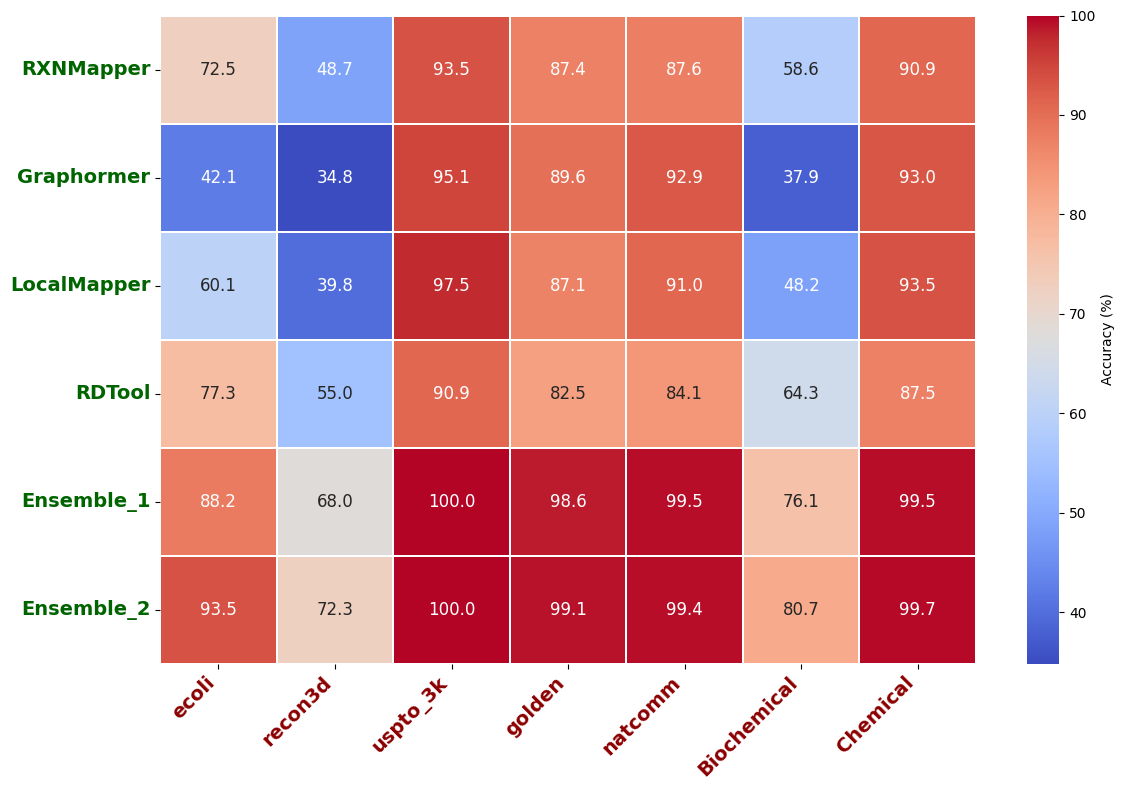

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'test' is your DataFrame and already includes the necessary data
heatmap_data = data_visual.set_index('mapper')  # Adjust this line if the DataFrame preparation differs

# Plotting
plt.figure(figsize=(12, 8))
# Heatmap with annotations and adjusted color map
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.3, linecolor='white', 
            cbar=True, cbar_kws={'label': 'Accuracy (%)', 'orientation': 'vertical'}, annot_kws={"size": 12})
# Enhancements for title and labels
#plt.title('Heatmap of Mapper Accuracies Across Datasets', fontsize=18, color='navy', fontweight='bold', pad=20)
# plt.xlabel('Dataset', fontsize=16, color='black', labelpad=10)
# plt.ylabel('Mapper', fontsize=16, color='black', labelpad=10)
plt.ylabel(None)
# Adjustments for tick marks
plt.xticks(rotation=45, ha='right', fontsize=14, fontweight='bold', color='darkred')
plt.yticks(rotation=0, fontsize=14, fontweight='bold', color='darkgreen')
plt.tight_layout()  # Ensure the layout fits without overlap
plt.savefig('./fig/aam_accuracy_heatmap.pdf', dpi = 600)
plt.show()


In [ ]:
final_df

## 3.2 Barplot

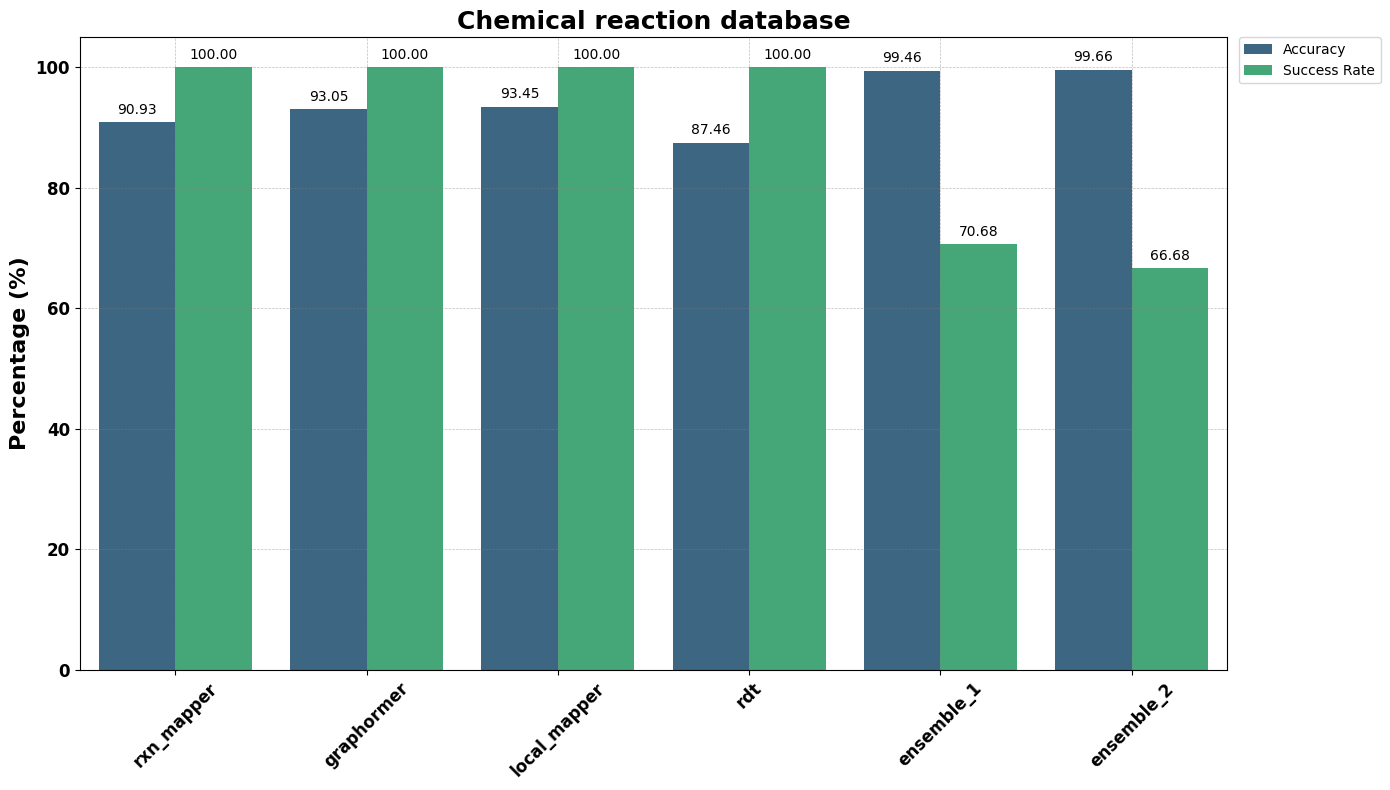

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_accuracy_success_rate_seaborn(df, accuracy_col, success_col):
    """
    Plots grouped bar charts for accuracy and success rates using Seaborn,
    from specified columns in a DataFrame.
    
    Parameters:
    - df: DataFrame containing the data
    - accuracy_col: string, name of the column with accuracy data
    - success_col: string, name of the column with success rate data
    """
    # Ensure the mapper is treated as categorical
    df['mapper'] = df['mapper'].astype(str)

    # Create a temporary DataFrame to facilitate Seaborn plotting
    temp_df = df[['mapper', accuracy_col, success_col]].melt(id_vars=['mapper'], 
                                                             var_name='Metric', 
                                                             value_name='Percentage')

    # Mapping the original column names to more user-friendly names
    temp_df['Metric'] = temp_df['Metric'].map({accuracy_col: 'Accuracy', success_col: 'Success Rate'})
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(14, 8))
    
    # Plot using Seaborn
    sns.barplot(x='mapper', y='Percentage', hue='Metric', data=temp_df, palette='viridis')

    # Adding labels above bars
    ax = plt.gca()
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only add annotations to bars with a non-zero height
            ax.annotate(format(height, '.2f'), 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')

    # Set title and labels with enhanced font settings
    plt.title('Chemical reaction database', fontsize=18, fontweight='bold')
    plt.xlabel(None)
    plt.ylabel('Percentage (%)', fontsize=16, fontweight='semibold')
    
    # Improve the appearance of ticks
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Adding a grid for better visual alignment
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

    # Adjust legend to prevent overlap with the bars
    plt.legend(title=None, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

df = final_df.copy()
plot_accuracy_success_rate_seaborn(df, 'Chemical_accuracy', 'Chemical_success_rate')


/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_21891/532892815.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, fontweight='bold')
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_21891/532892815.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(x)}%' for x in ax.get_yticks()], fontsize=12, fontweight='bold')
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_21891/532892815.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, fontweight='bold')
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_21891/532892815.py:51: UserWarning: set_t

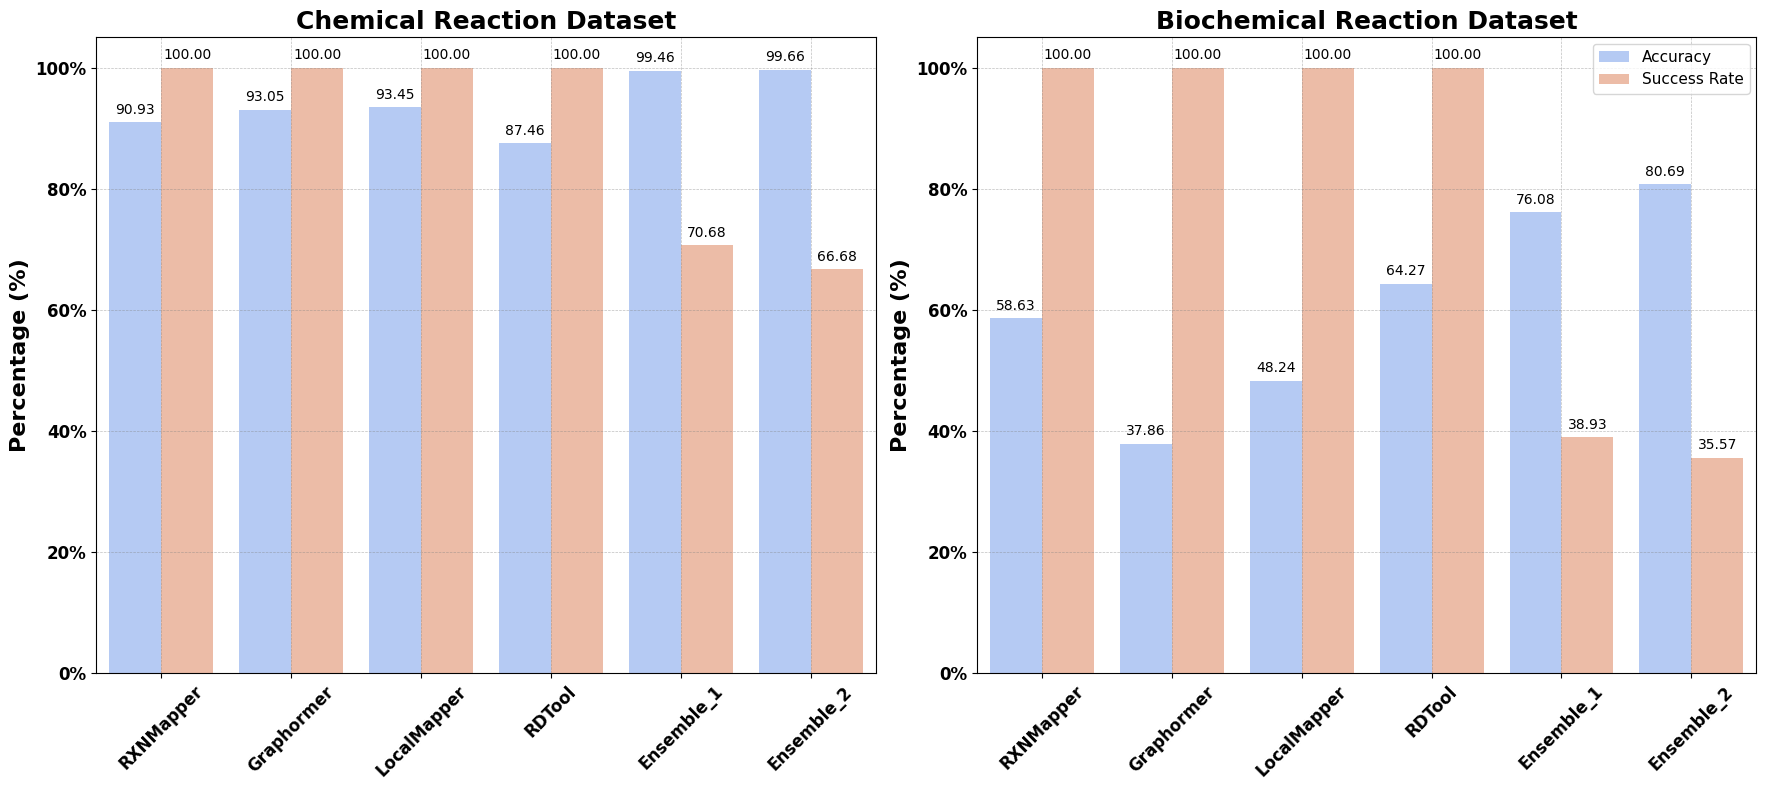

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_accuracy_success_rate_subplot(df, accuracy_cols, success_cols, titles):
    """
    Plots 1x2 subplots for accuracy and success rates using Seaborn,
    from specified columns in a DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - accuracy_cols: list of strings, names of the columns with accuracy data
    - success_cols: list of strings, names of the columns with success rate data
    - titles: list of strings, titles for each subplot
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1x2 subplot layout

    for idx, ax in enumerate(axes):
        # Ensure the mapper is treated as categorical
        df['mapper'] = df['mapper'].astype(str)

        # Create a temporary DataFrame to facilitate Seaborn plotting
        temp_df = df[['mapper', accuracy_cols[idx], success_cols[idx]]].melt(id_vars=['mapper'], 
                                                                            var_name='Metric', 
                                                                            value_name='Percentage')

        # Mapping the original column names to more user-friendly names
        temp_df['Metric'] = temp_df['Metric'].map({accuracy_cols[idx]: 'Accuracy', success_cols[idx]: 'Success Rate'})
        
        # Plot using Seaborn on the specified axis
        sns.barplot(x='mapper', y='Percentage', hue='Metric', data=temp_df, palette='coolwarm', ax=ax)

        # Adding labels above bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0:  # Only add annotations to bars with a non-zero height
                ax.annotate(format(height, '.2f'), 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', 
                            xytext=(0, 9), 
                            textcoords='offset points')

        # Set title and labels with enhanced font settings for each subplot
        ax.set_title(titles[idx], fontsize=18, fontweight='bold')
        ax.set_xlabel(None)
        ax.set_ylabel('Percentage (%)', fontsize=16, fontweight='semibold')
        
        # Improve the appearance of ticks
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, fontweight='bold')
        ax.set_yticklabels([f'{int(x)}%' for x in ax.get_yticks()], fontsize=12, fontweight='bold')

        # Adding a grid for better visual alignment
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

        # Adjust legend to prevent overlap with the bars
        
        if idx != 0:
            ax.legend(title=None, bbox_to_anchor=(0.79, 0.99), loc=2, borderaxespad=0., fontsize=11)
        else:
            ax.legend([],[], frameon=False)
    plt.tight_layout()
    plt.savefig('./fig/aam_accuracy_barplot.pdf', dpi = 600)
    plt.show()

df = final_df.copy()

df['mapper'] = ['RXNMapper', 'Graphormer', 'LocalMapper', 'RDTool', 'Ensemble_1', 'Ensemble_2']
plot_accuracy_success_rate_subplot(df, ['Chemical_accuracy', 'Biochemical_accuracy'], ['Chemical_success_rate', 'Biochemical_success_rate'], 
                                   ['Chemical Reaction Dataset', 'Biochemical Reaction Dataset'])


In [28]:
data_visual

,mapper,ecoli,recon3d,uspto_3k,golden,natcomm,Biochemical,Chemical
0,RXNMapper,72.53,48.69,93.53,87.43,87.58,58.63,90.93
1,Graphormer,42.12,34.82,95.10,89.59,92.87,37.86,93.05
2,LocalMapper,60.07,39.79,97.53,87.14,91.04,48.24,93.45
3,RDTool,77.29,54.97,90.90,82.54,84.11,64.27,87.46
4,Ensemble_1,88.24,67.97,100.00,98.59,99.47,76.08,99.46
5,Ensemble_2,93.48,72.34,100.00,99.14,99.43,80.69,99.66
